# 8-bit quantization with per signal min-max normalization

The code implementing this is in `quantized_data.py`. It is imported by EDA for the new split.

In [4]:
# given
import struct
from pathlib import Path


BASE_DIR = Path().resolve()

data_path = BASE_DIR / "data"  # Directory to store data files
train_data_path = data_path / "X_train.bin"
test_data_path = data_path / "X_test.bin"
train_label_path = data_path / "y_train.csv"


def ragged_read_binary(path):
    ragged_array = []
    with open(path, "rb") as r:
        read_binary_from(ragged_array, r)
    return ragged_array


def read_binary_from(ragged_array, r):
    while True:
        size_bytes = r.read(4)
        if not size_bytes:
            break
        sub_array_size = struct.unpack("i", size_bytes)[0]
        sub_array = list(
            struct.unpack(f"{sub_array_size}h", r.read(sub_array_size * 2))
        )
        sub_array = [int(x) for x in sub_array]
        ragged_array.append(sub_array)

In [5]:
from pathlib import Path
import numpy as np
import zipfile
import shutil
import tempfile

signals = ragged_read_binary(train_data_path)  
signals = [np.array(sig, dtype=np.float32) for sig in signals]

from quantized_data import read_quantized_zip, write_quantized_zip

output_dir = BASE_DIR
zip_name = "quantized_signals.zip"
write_quantized_zip(signals, output_dir, zip_name)


if (output_dir / zip_name).exists():
    print(f"Zipped CSV file created at: {(output_dir / zip_name)}")

restored_signals = read_quantized_zip((output_dir / zip_name))
mse_list = [np.mean((orig - restored) ** 2) for orig, restored in zip(signals, restored_signals)]
mae_list = [np.mean(np.abs(orig - restored)) for orig, restored in zip(signals, restored_signals)]

print(f"Mean MSE: {np.mean(mse_list):.6f}")
print(f"Max MSE: {np.max(mse_list):.6f}")
print(f"Min MSE: {np.min(mse_list):.6f}")

print(f"Mean MAE: {np.mean(mae_list):.6f}")
print(f"Max MAE: {np.max(mae_list):.6f}")
print(f"Min MAE: {np.min(mae_list):.6f}")

print(f"Total original size: {sum(sig.nbytes for sig in signals) / (1024 * 1024):.2f} MBs")
print(f"Total restored size: {sum(sig.nbytes for sig in restored_signals) / (1024 * 1024):.2f} MBs")
print(f"Zipped file size: {(output_dir / zip_name).stat().st_size / (1024 * 1024):.2f} MBs")

original_zip_path = data_path / "original_signals.zip"
with zipfile.ZipFile(original_zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(train_data_path, arcname="X_train.bin")

print(f"Original signals zipped size: {original_zip_path.stat().st_size / (1024 * 1024):.2f} MBs")



Zipped CSV file created at: /Users/selin/Uni/AMLS/ecg-timeseries-model/Dataset_Exploration/quantized_signals.zip
Mean MSE: 11.684496
Max MSE: 252.923660
Min MSE: 0.119471
Mean MAE: 2.345962
Max MAE: 13.755458
Min MAE: 0.296191
Total original size: 230.06 MBs
Total restored size: 230.06 MBs
Zipped file size: 32.87 MBs
Original signals zipped size: 61.16 MBs


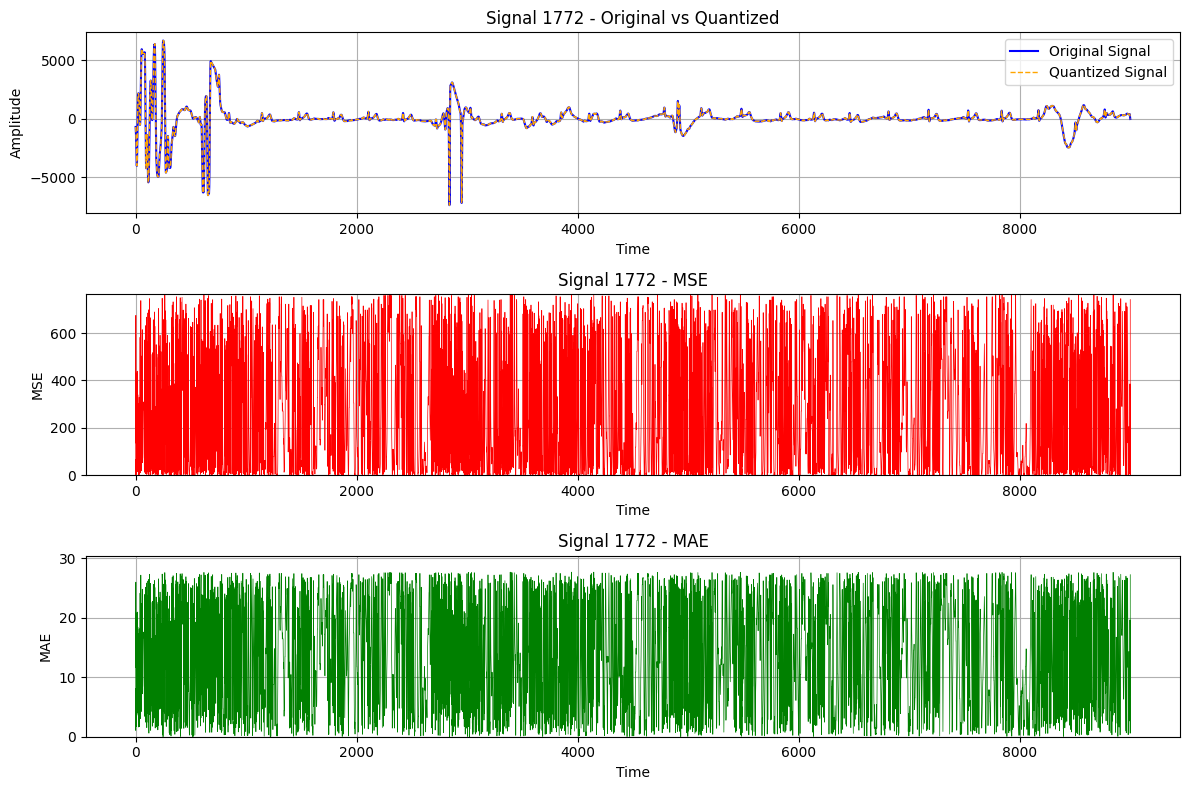

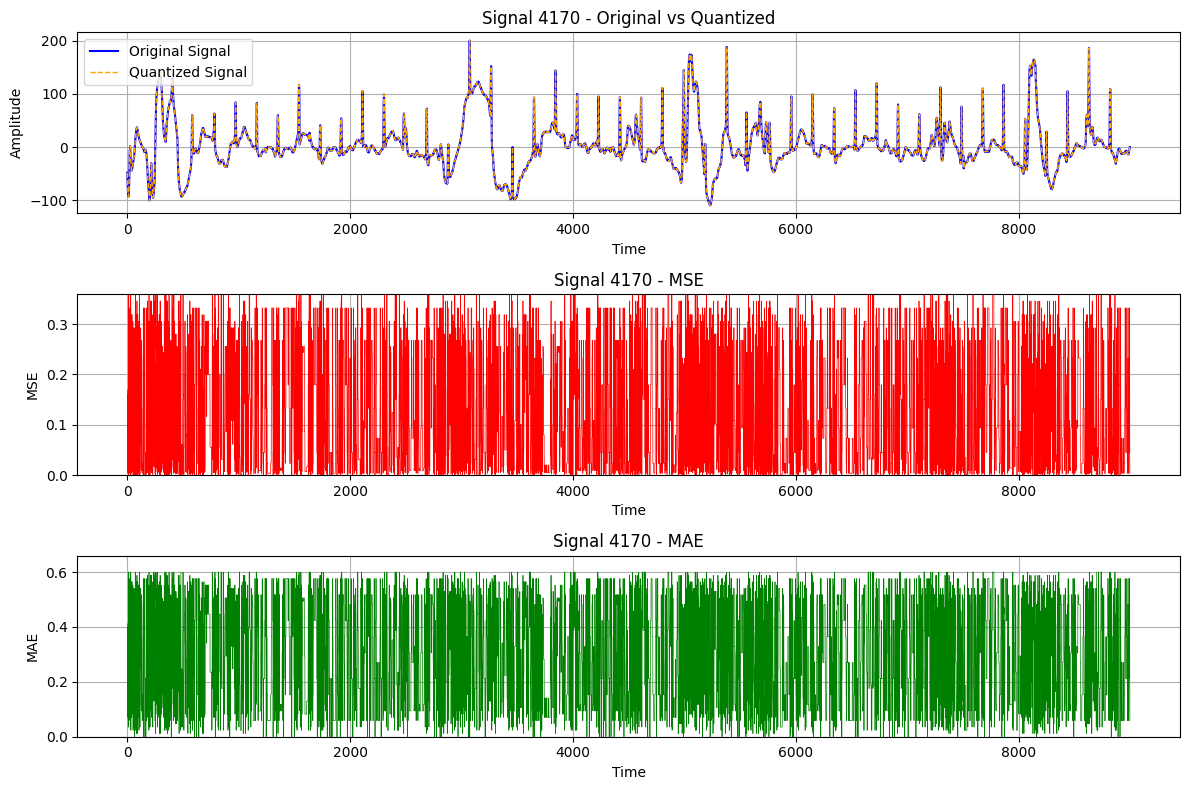

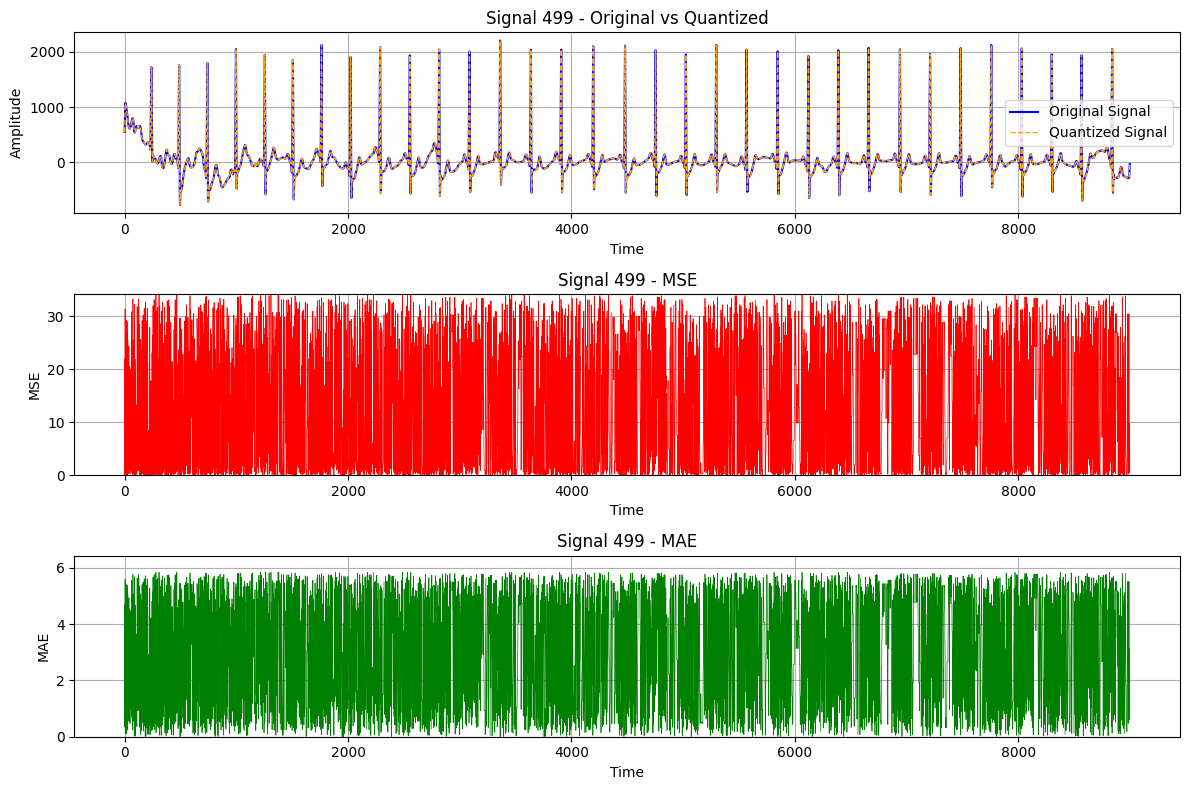

In [7]:
# visualize actual signal over the quantized signal
import matplotlib.pyplot as plt

def plot_signals(original, quantized, index=0, error_interval=None):
    # two plots: original & quantized and error
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    axs[0].plot(original[index], label='Original Signal', color='blue')
    axs[0].plot(
        quantized[index],
        label="Quantized Signal",
        color="orange",
        linestyle="dashed",
        linewidth=1,
    )
    axs[0].set_title(f'Signal {index} - Original vs Quantized')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Amplitude')
    axs[0].legend() 
    axs[0].grid()

    mse_error = (original[index] - quantized[index])**2

    axs[1].plot(mse_error, label='MSE', color='red', linewidth=0.5)
    axs[1].set_title(f'Signal {index} - MSE')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('MSE')
    # adjust the x-axis limits if error_interval is provided
    if error_interval is not None:
        axs[1].set_ylim(-error_interval, error_interval)
    else:
        axs[1].set_ylim(np.min(mse_error), np.max(mse_error))
    axs[1].grid()

    mae_error = np.abs(original[index] - quantized[index])
    axs[2].plot(mae_error, label='MAE', color='green', linewidth=0.5)
    axs[2].set_title(f'Signal {index} - MAE')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('MAE')
    axs[2].set_ylim(0, np.max(mae_error) * 1.1)
    axs[2].grid()
    
    plt.tight_layout()
    plt.show()


max_mse_index = np.argmax(mse_list)
plot_signals(signals, restored_signals, index=max_mse_index)

min_mse_index = np.argmin(mse_list)
plot_signals(signals, restored_signals, index=min_mse_index)

mean_mse_index = np.argmin(np.abs(np.array(mse_list) - np.mean(mse_list)))
plot_signals(signals, restored_signals, index=mean_mse_index)

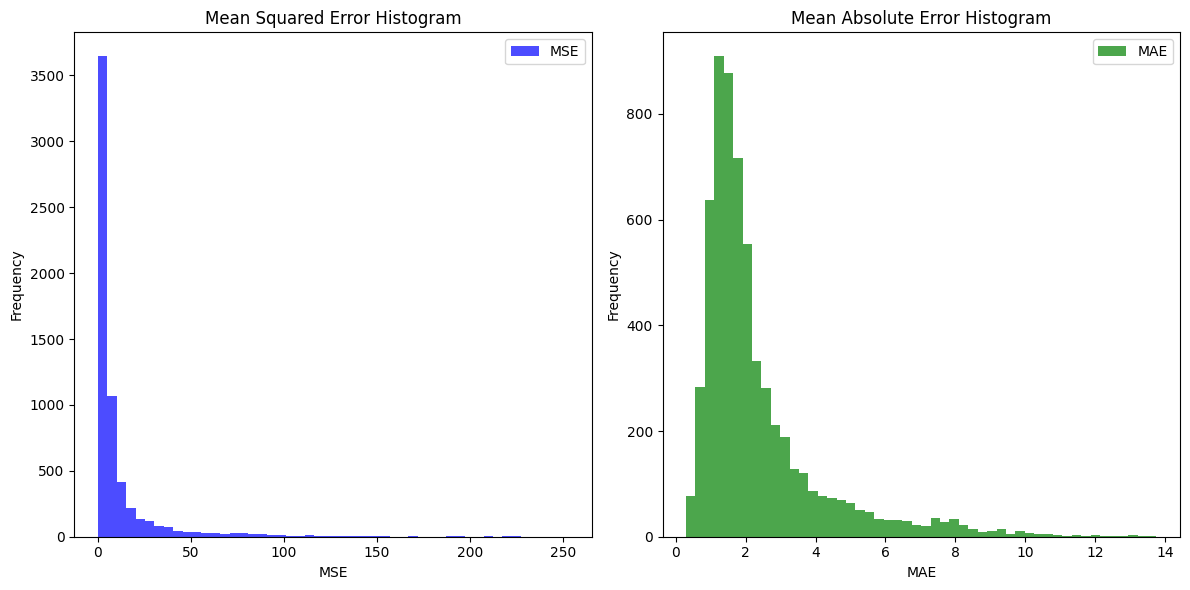

In [10]:
# histogram of MSE and MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(mse_list, bins=50, color='blue', alpha=0.7, label='MSE')
plt.title('Mean Squared Error Histogram')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(mae_list, bins=50, color='green', alpha=0.7, label='MAE')
plt.title('Mean Absolute Error Histogram')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()